нужно провести эксперимент с моделью ARIMA для предсказания временного ряда.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

%matplotlib inline

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [4]:
series = pd.read_csv("./mean-monthly-air-temperature-deg.csv")['Deg']

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


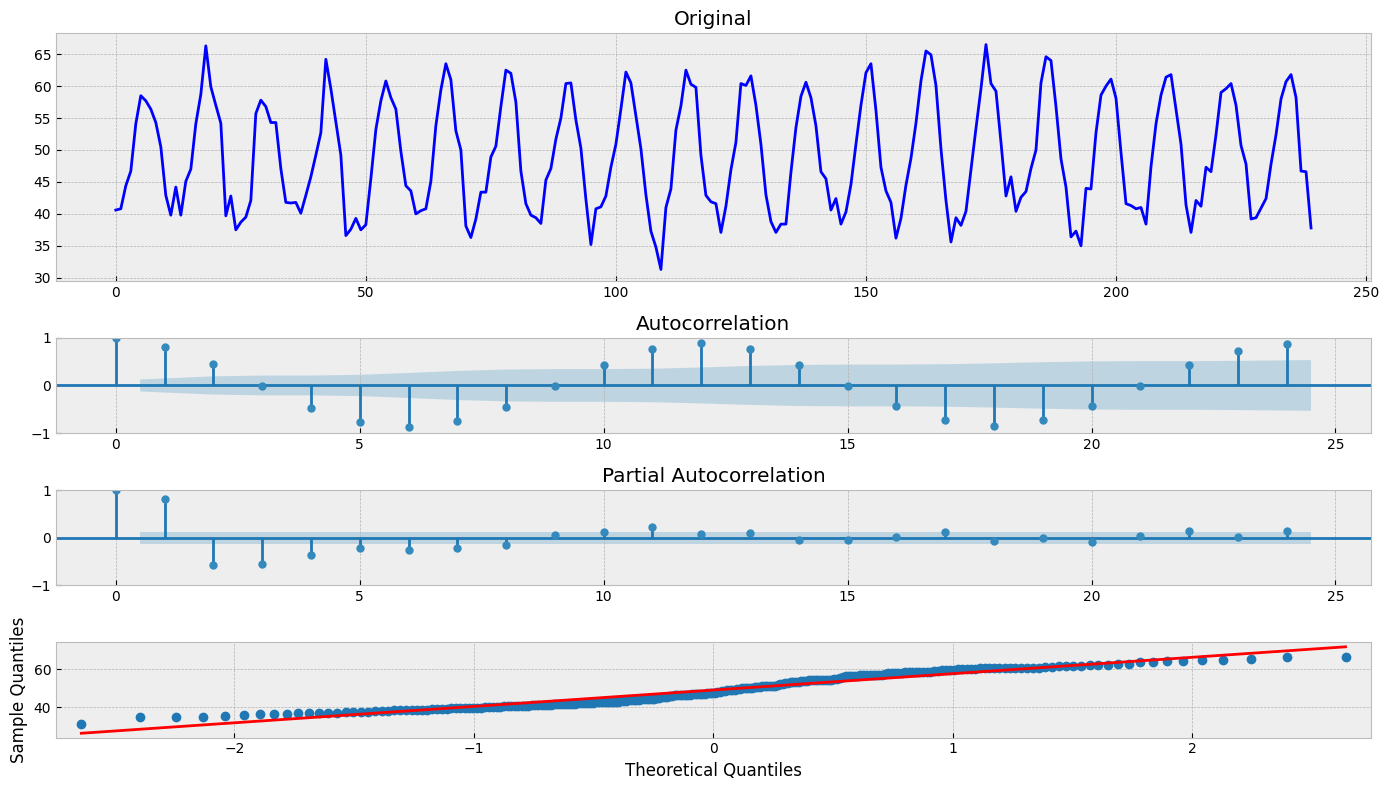

In [5]:
tsplot(series)

Тк график не стационарный (есть тренд и сезонность) - сделаем его таковым

Results of Dickey-Fuller Test:
Test Statistic                  -3.760996
p-value                          0.003333
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


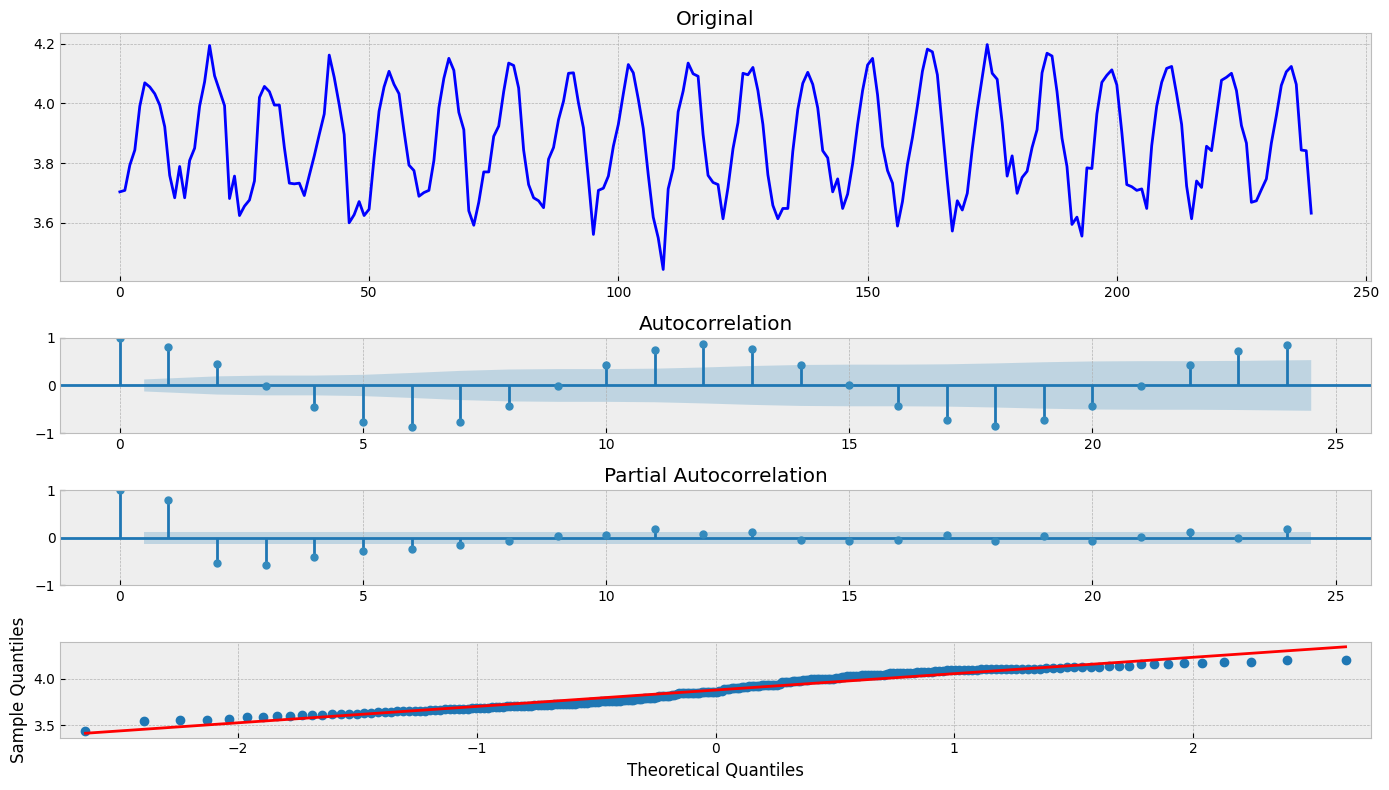

In [6]:
series = boxcox(series, 0) #Box-Cox - устраняем неоднородность дисперсии
tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                -1.214226e+01
p-value                        1.640728e-22
#Lags Used                     1.100000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


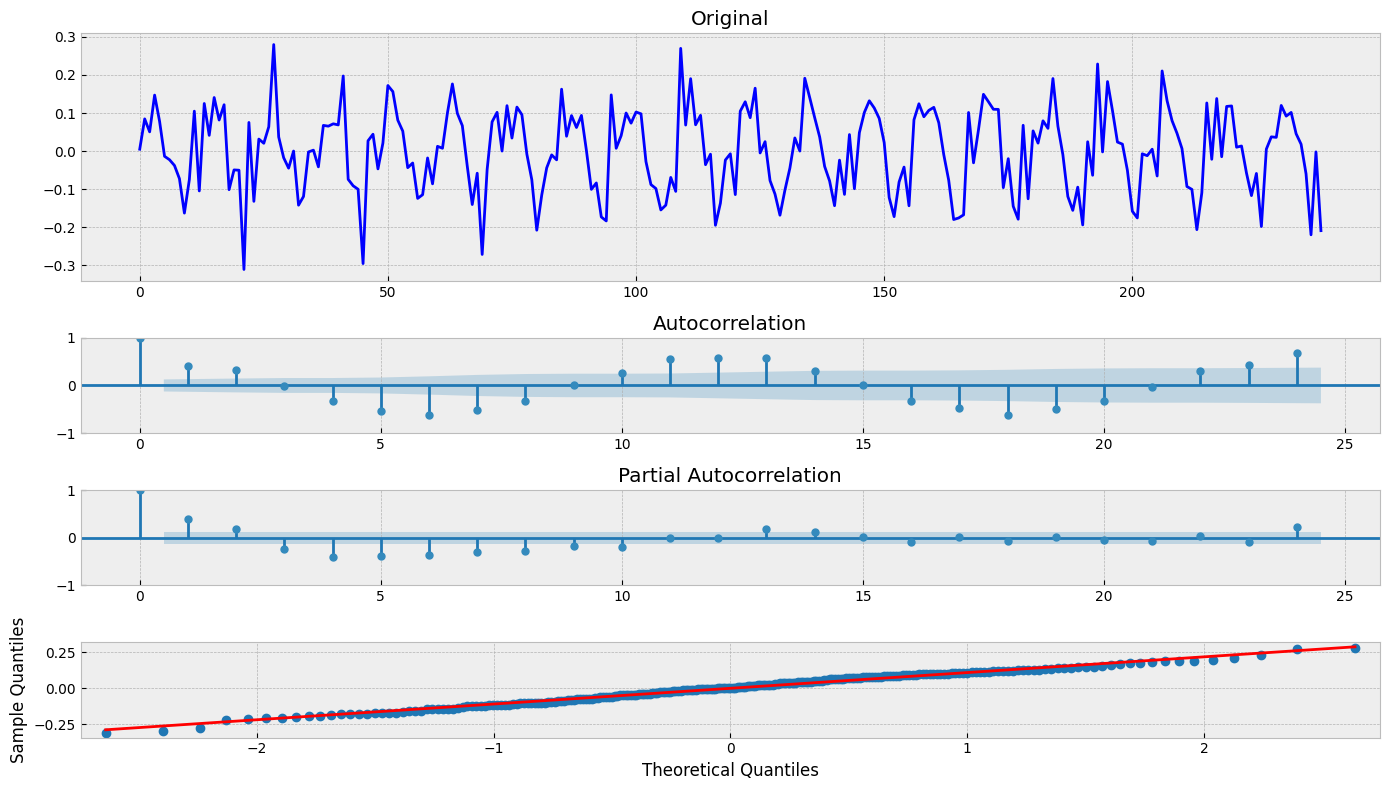

In [7]:
series = series[1:] - series[:-1] # 1 Дифференцирование
tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                -7.999033e+00
p-value                        2.361164e-12
#Lags Used                     1.500000e+01
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64


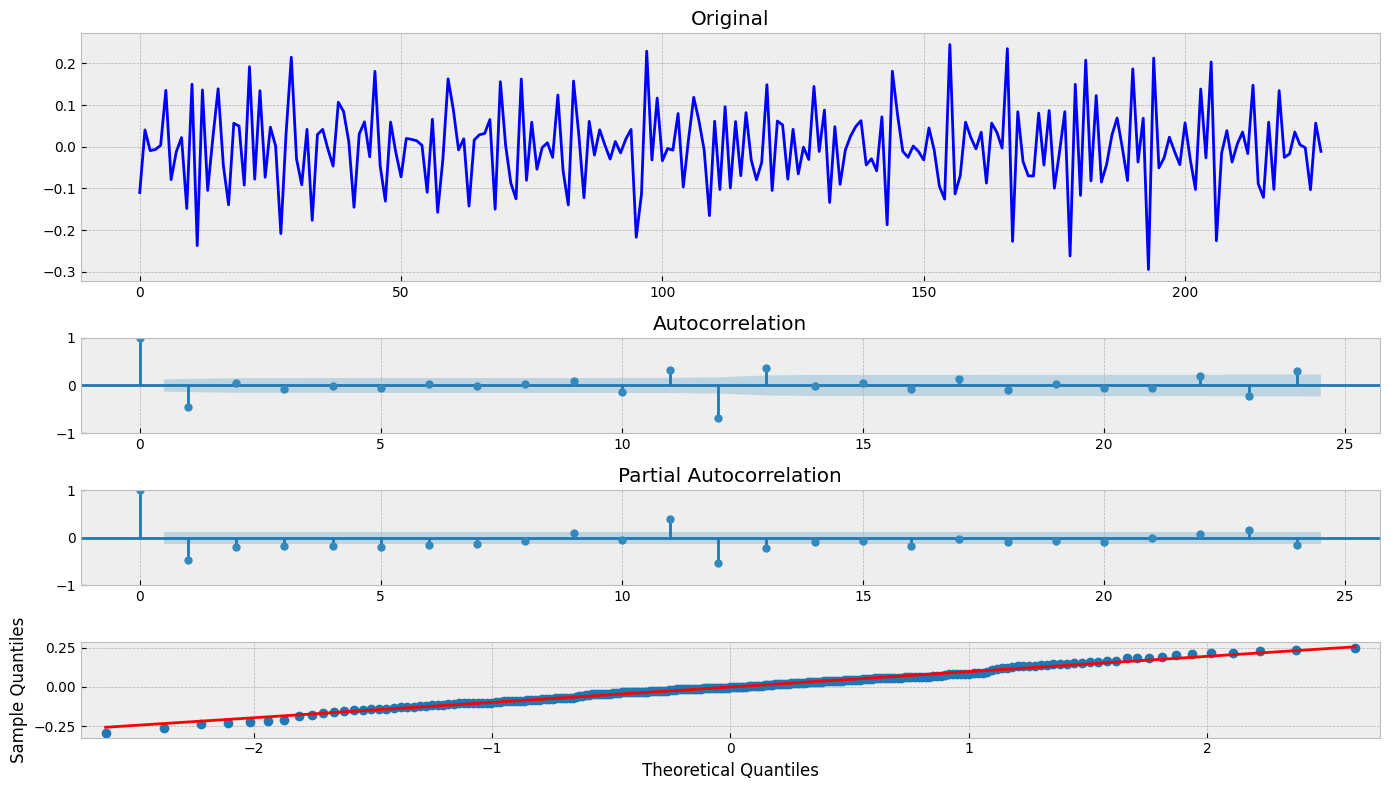

In [8]:
series = series[12:] - series[:-12] # сезонное Дифференцирование
tsplot(series)

/Users/mariabelakova/Documents/учеба/projects-Data-Engineer/myenv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mariabelakova/Documents/учеба/projects-Data-Engineer/myenv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/mariabelakova/Documents/учеба/projects-Data-Engineer/myenv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/mariabelakova/Documents/учеба/projects-Data-Engineer/myenv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likeli

aic: -540.92988 | order: (3, 0, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -4.381892
p-value                          0.000320
#Lags Used                      15.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


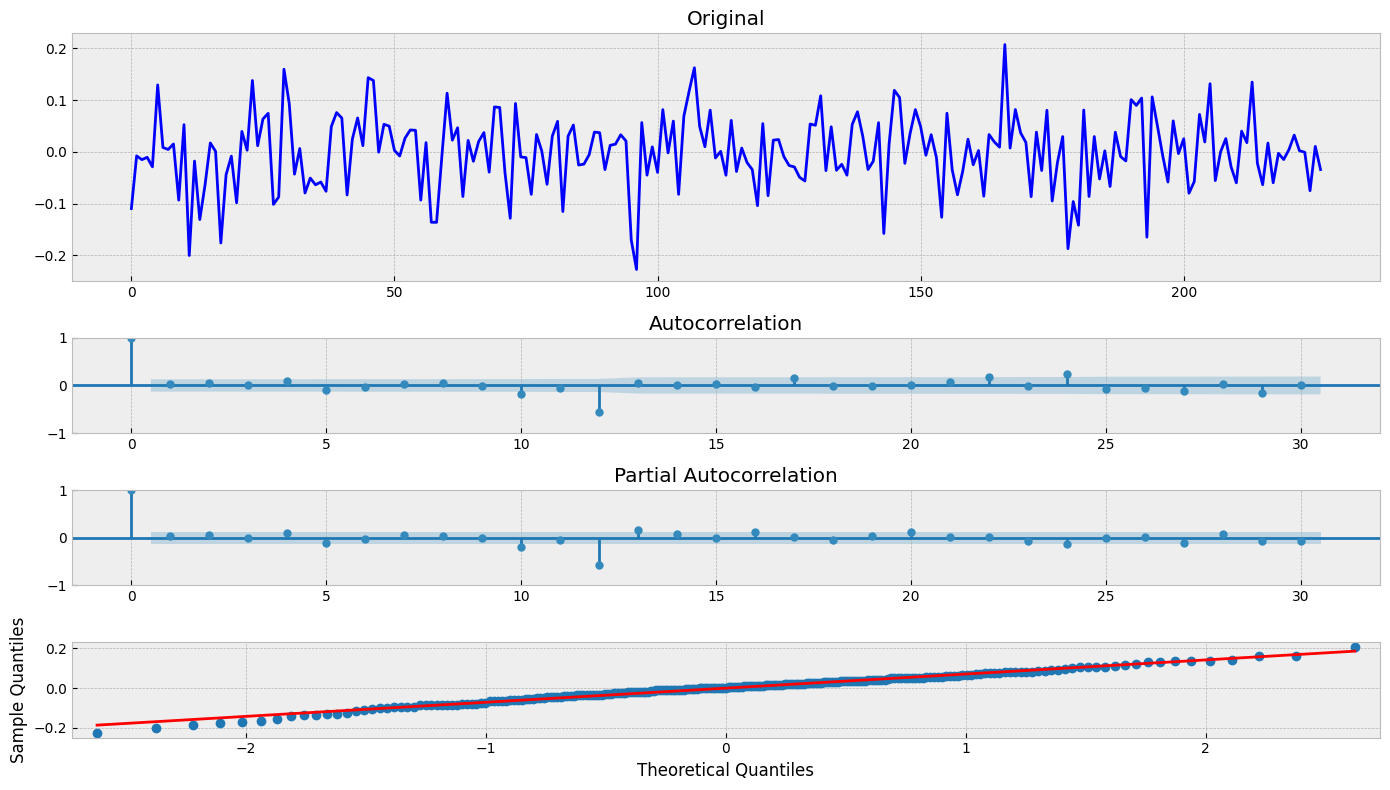

In [9]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i, d, j), trend='n').fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

tsplot(best_mdl.resid, lags=30)

Оптимальная модель ARIMA(3, 0, 4) с AIC = -540.93
Results of Dickey-Fuller Test:
Test Statistic                  -4.381892
p-value                          0.000320
#Lags Used                      15.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


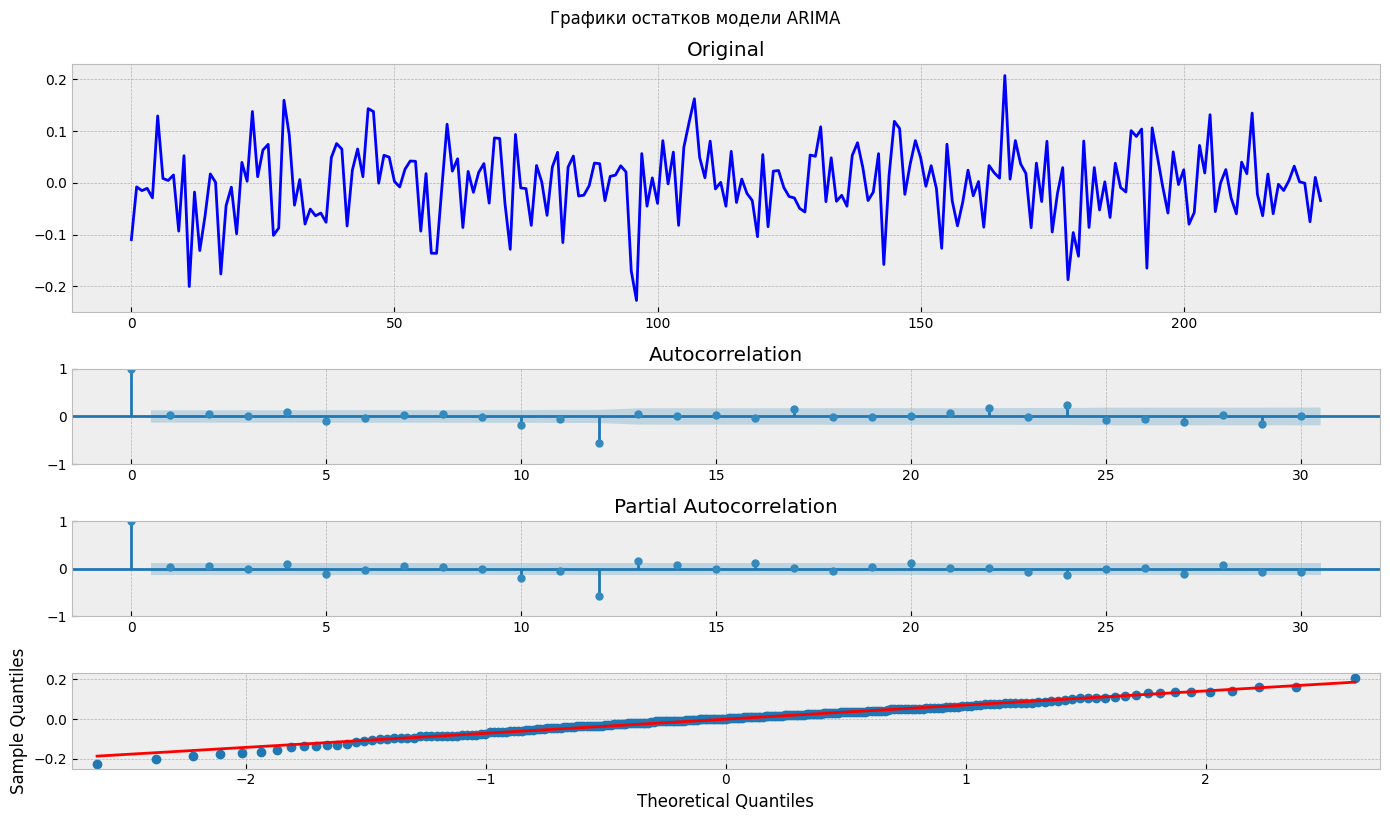

In [10]:
print(f"Оптимальная модель ARIMA{best_order} с AIC = {best_aic:.2f}")

tsplot(best_mdl.resid, lags=30)
plt.suptitle("Графики остатков модели ARIMA", y=1.02)
plt.show()

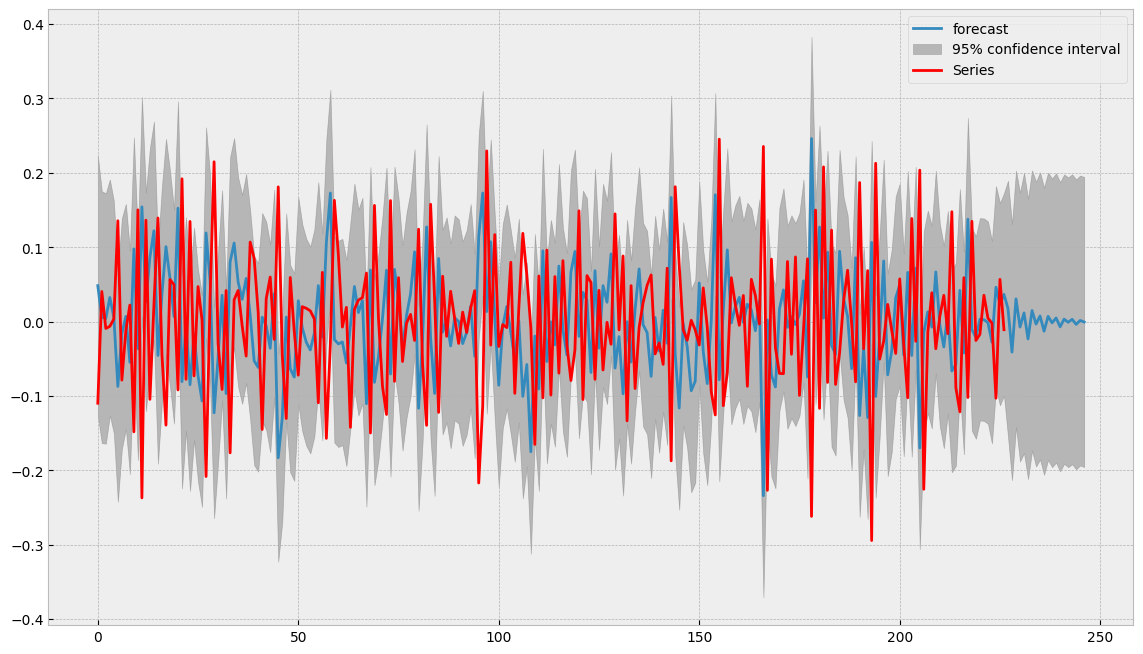

In [12]:
from statsmodels.graphics.tsaplots import plot_predict

with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(best_mdl, 1, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

## Вывод: модель ARIMA описывает динамику ряда, остатки ведут себя как белый шум, p-value 0.000320 < 0.05, что подтверждает адекватность модели.